In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from __future__ import print_function, absolute_import

import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from pydrake.all import (
    DiagramBuilder,
    FloatingBaseType,
    RigidBodyTree,
    RigidBodyPlant,
    SignalLogger, 
    Simulator, 
    VectorSystem
)
# from pydrake.examples.pendulum import PendulumPlant
from pydrake.systems.controllers import (
    DynamicProgrammingOptions, FittedValueIteration, PeriodicBoundaryCondition)
from visualizer import PendulumVisualizer
# from pydrake.examples.acrobot import AcrobotPlant
from underactuated import (
    PlanarRigidBodyVisualizer
)

In [2]:
tree = RigidBodyTree("/opt/underactuated/src/cartpole/cartpole.urdf",
                     FloatingBaseType.kFixed)
plant = RigidBodyPlant(tree)

simulator = Simulator(plant)
options = DynamicProgrammingOptions()

# State: (theta1, theta2, theta1_dot, theta2_dot) Input: Elbow torque

def min_time_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    u = plant.EvalVectorInput(context, 0).CopyToVector()
    x[1] = x[1] - math.pi
    if x.dot(x) < .1: # seeks get x to (0., math.pi, 0., 0.)
        return 0.
    return 1. + 2*x.dot(x)/(10**2+math.pi**2+10**2+math.pi**2) + u.dot(u)/(180**2)


def quadratic_regulator_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    x[1] = x[1] - math.pi
    u = plant.EvalVectorInput(context, 0).CopyToVector()
#     return 2*x.dot(x)/(10**2+math.pi**2+10**2+math.pi**2) + u.dot(u)/(180**2)
    return 2*x.dot(x)/(10**2+math.pi**2+10**2+math.pi**2) + u.dot(u)/(180)


if (True):
    cost_function = min_time_cost
    input_limit = 180.
    options.convergence_tol = 0.001
#     options.convergence_tol = 0.003
    state_steps = 19
    input_steps = 19
else:
    cost_function = quadratic_regulator_cost
    input_limit = 250.
    options.convergence_tol = 0.01
    state_steps = 19
    input_steps = 19

####### SETTINGS ####### My cartpole linspaces are off??????
# State: (x, theta, x_dot, theta_dot)
# Previous Best... (min. time) (3)
xbins = np.linspace(-10., 10., state_steps)
thetabins = np.hstack((np.linspace(0., math.pi-0.2, 8), np.linspace(math.pi-0.2, math.pi+0.2, 11), np.linspace(math.pi+0.2, 8, 2*math.pi)))
xdotbins = np.linspace(-10., 10., state_steps)
thetadotbins = np.linspace(-10., 10., state_steps)
timestep = 0.01

# Test 1 (4)
xbins = np.linspace(-10., 10., state_steps)
thetabins = np.hstack((np.linspace(0., math.pi-0.12, 8), np.linspace(math.pi-0.12, math.pi+0.12, 11), np.linspace(math.pi+0.12, 8, 2*math.pi)))
xdotbins = np.linspace(-10., 10., state_steps+2)
thetadotbins = np.hstack((np.linspace(-10., -1.5, 9), np.linspace(-1.5, 1.5, 11), np.linspace(1.5, 10., 9)))
# timestep = 0.001 <- wasn't active...

# Test 2 - Test 1 was worse? WOW I HAD A BUG! - in my last np.linspace  (5) SWEET!!!
xbins = np.linspace(-10., 10., state_steps)
thetabins = np.hstack((np.linspace(0., math.pi-0.2, 10), np.linspace(math.pi-0.2, math.pi+0.2, 9), np.linspace(math.pi+0.2, 2*math.pi, 10)))
xdotbins = np.linspace(-10., 10., state_steps+2)
thetadotbins = np.linspace(-10., 10., state_steps)
timestep = 0.01
input_limit = 250. # test_stabilize_top7 for the higher input_limit version

# Test 3 - Let's try increasing the state and penalty costs a bit more? (6)
# xbins = np.linspace(-10., 10., state_steps)
# thetabins = np.hstack((np.linspace(0., math.pi-0.2, 10), np.linspace(math.pi-0.2, math.pi+0.2, 11), np.linspace(math.pi+0.2, 2*math.pi, 10)))
# xdotbins = np.linspace(-10., 10., state_steps+2)
# thetadotbins = np.linspace(-10., 10., state_steps)
# timestep = 0.01
# def my_cost(context):
#     x = context.get_continuous_state_vector().CopyToVector()
#     u = plant.EvalVectorInput(context, 0).CopyToVector()
#     x[1] = x[1] - math.pi
#     if x.dot(x) < .1: # seeks get x to (math.pi, 0., 0., 0.) # I should really try to get rid of this if statement from my cost function...
#         return 0.
#     return 1. + x.dot(x)/10 + u.dot(u)/1000 # About 20x increase in both constants...
# cost_function = my_cost

# Test 4, let's try doing just quadratic cost, all other settings the same.

# Test log:
# 1) Adding more data points to middle of thetadot range to try and stabilize the upright position more...?
# 2) Also added some state_steps...


options.periodic_boundary_conditions = [
    PeriodicBoundaryCondition(1, 0., 2.*math.pi),
]
state_grid = [set(xbins), set(thetabins), set(xdotbins), set(thetadotbins)]
input_grid = [set(np.linspace(-input_limit, input_limit, input_steps))] # Input: x force
# timestep = 0.01

# [Q, Qdot] = np.meshgrid(xbins, thetabins)
# # [Q, Qdot] = np.meshgrid(qbins, qbins2)
# # [Q, Qdot] = np.meshgrid(qbins, qbins2, qdotbins, qdotbins2)
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ax.set_xlabel("theta")
# ax.set_ylabel("thetadot")

# fig2 = plt.figure()
# ax2 = fig2.gca(projection='3d')
# ax2.set_xlabel("q")
# ax2.set_ylabel("qdot")


# def draw(iteration, mesh, cost_to_go, policy):
#     # Drawing is slow, don't draw every frame.
#     if iteration % 10 != 0:
#         return
#     plt.title("iteration " + str(iteration))
#     J = np.reshape(cost_to_go, Q.shape)
#     surf = ax.plot_surface(Q, Qdot, J, rstride=1, cstride=1,
#                            cmap=cm.jet)

#     Pi = np.reshape(policy, Q.shape)
#     surf2 = ax2.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1, cmap=cm.jet)

#     display.display(plt.gcf())
#     display.clear_output(wait=True)


# options.visualization_callback = draw

# policy, cost_to_go = FittedValueIteration(simulator, cost_function,
#                                           state_grid, input_grid,
#                                           timestep, options)


/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


In [3]:
from pydrake.all import (BarycentricMesh, BarycentricMeshSystem)
def save_policy(name): # binds to policy, state_grid, and cost_to_go
    output_values = policy.get_output_values()
    np.save('numpy_saves/pi_b_mesh_init__cartpole_'+name, state_grid)
    np.save('numpy_saves/pi_output_values__cartpole_'+name, output_values)
    np.save('numpy_saves/ctg__cartpole_'+name, cost_to_go)
def load_policy(name):
    b_mesh_init = np.load('numpy_saves/pi_b_mesh_init__cartpole_'+name+'.npy').tolist()
    output_values = np.load('numpy_saves/pi_output_values__cartpole_'+name+'.npy')
    b_mesh = BarycentricMesh(b_mesh_init)
    ctg = np.load('numpy_saves/ctg__cartpole_'+name+'.npy')
    return BarycentricMeshSystem(b_mesh, output_values), ctg
# save_policy('test_stabilize_top7_w_ctg')
policy, cost_to_go = load_policy('test_stabilize_top7_w_ctg')

In [10]:
# Animate the resulting policy.
builder = DiagramBuilder()
tree = RigidBodyTree("/opt/underactuated/src/cartpole/cartpole.urdf",
                     FloatingBaseType.kFixed)
plant = RigidBodyPlant(tree)
plant_system = builder.AddSystem(plant)


# TODO(russt): add wrap-around logic to barycentric mesh
# (so the policy has it, too)
class WrapTheta(VectorSystem):
    def __init__(self):
        VectorSystem.__init__(self, 4, 4)

    def _DoCalcVectorOutput(self, context, input, state, output):
        output[:] = input
        twoPI = 2.*math.pi
        output[1] = output[1] - twoPI * math.floor(output[1] / twoPI)


wrap = builder.AddSystem(WrapTheta())
builder.Connect(plant_system.get_output_port(0), wrap.get_input_port(0))
# vi_policy = builder.AddSystem(test)
vi_policy = builder.AddSystem(policy)
builder.Connect(wrap.get_output_port(0), vi_policy.get_input_port(0))
builder.Connect(vi_policy.get_output_port(0), plant_system.get_input_port(0))

logger = builder.AddSystem(SignalLogger(4))
logger._DeclarePeriodicPublish(0.033333, 0.0)
builder.Connect(plant_system.get_output_port(0), logger.get_input_port(0))

diagram = builder.Build()
simulator = Simulator(diagram)
simulator.set_publish_every_time_step(False)

state = simulator.get_mutable_context().get_mutable_continuous_state_vector()
state.SetFromVector([-1., math.pi-1, 1., -1.])

In [11]:
simulator.StepTo(10.)

In [12]:
# Visualize the result as a video.
# vis = PendulumVisualizer()
vis = PlanarRigidBodyVisualizer(tree, xlim=[-12.5, 12.5], ylim=[-1, 2.5])
ani = vis.animate(logger, repeat=True)

# plt.show()λ 
# Things added to get visualizations in an ipynb
plt.close(vis.fig)
HTML(ani.to_html5_video())

/home/rverkuil/integration/integration/local/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


## Let's verify the cost to go against cost of many random (w/ random inits) dircols!

In [4]:
from pydrake.all import (
    BarycentricMesh,
    DirectCollocation, 
    PiecewisePolynomial, 
    SolutionResult,
)
from traj.vi_utils import do_dircol_cartpole


def do_dircol(ic, warm_start="linear", seed=1776, should_vis=False):
    return do_dircol_cartpole(ic           = ic, 
                       warm_start   = warm_start, 
                       seed         = seed, 
                       should_vis   = should_vis,
                       torque_limit = 250.,
#                        num_samples  = 42, 
                       min_timestep = 0.0001,
                       max_timestep = 1.)

In [16]:
%matplotlib notebook


from pydrake.all import (SolutionResult)

# Gen a bunch of random initial conditions
n = 4
xs = np.random.uniform(-10, 10, n)
thetas = np.random.uniform(0, 2*math.pi, n)
xdots = np.random.uniform(-10, 10, n)
thetadots = np.random.uniform(-10, 10, n)

ics = [(x, theta, xdot, thetadot) for x in xs for theta in thetas for xdot in xdots for thetadot in thetadots]


def eval_policy(x):
    mesh = policy.get_mesh()
    ovs  = policy.get_output_values()
    return mesh.Eval(ovs, x)
def eval_ctg(x):
    bary_cost_to_go = BarycentricMesh(state_grid)
    return bary_cost_to_go.Eval(cost_to_go.reshape(1, -1), np.array(x))


def f1(ic):
    dircol, result  = do_dircol(ic=ic, warm_start="random", seed=1776, should_vis=False)
    valid = True
    if result != SolutionResult.kSolutionFound:# or sum_cost > 350.:
        valid = False
    
    sum_cost        = np.sum(np.abs([dircol.EvalBindingAtSolution(cost) for cost in dircol.GetAllCosts()]))
    sum_constraints = np.sum([np.sum(np.abs(dircol.EvalBindingAtSolution(constraint))) for constraint in dircol.GetAllConstraints()])
    found_ctg       = sum_cost# + sum_constraints
    expected_ctg    = eval_ctg(ic)
    
    times   = dircol.GetSampleTimes().T
    x_knots = dircol.GetStateSamples().T
    u_knots = dircol.GetInputSamples().T
    assert len(times) == len(x_knots) and len(x_knots) == len(u_knots)
    t = times[0]
    x = x_knots[0]
    u = u_knots[0]

    expected_u = eval_policy(x)
    found_u    = u
#     print("expected_u {} found_u {}".format(expected_u, found_u))
    
    found_t = times[-1]
    expected_t = 0
    print("expected_t {} found_t {}".format(expected_t, found_t))

    return  valid, ic, found_ctg, expected_ctg, found_u, expected_u, found_t, expected_t

import multiprocessing
from multiprocessing import Pool

p = Pool(multiprocessing.cpu_count() - 2)
results = p.map(f1, ics)
p.close()

valids, ics, found_ctgs, expected_ctgs, found_us, expected_us, found_ts, expected_ts = (np.array(item) for item in zip(*results))


result=SolutionResult.kInfeasibleConstraints
expected_t 0 found_t 6.08381929757
expected_t 0 found_t 2.80077403701
expected_t 0 found_t 2.27056185459
expected_t 0 found_t 1.91076733116
expected_t 0 found_t 2.17356822074
expected_t 0 found_t 2.34368421609
expected_t 0 found_t 2.09549826485
expected_t 0 found_t 2.09771331587
expected_t 0 found_t 2.40108294758
expected_t 0 found_t 2.47879227983
expected_t 0 found_t 2.40722805688
expected_t 0 found_t 2.04719084461
expected_t 0 found_t 2.29837301474
expected_t 0 found_t 2.54772249914
expected_t 0 found_t 2.92199958282
expected_t 0 found_t 2.37203010717
expected_t 0 found_t 1.9563993281
expected_t 0 found_t 2.56188320262
expected_t 0 found_t 2.57199806403
expected_t 0 found_t 2.21637551704
expected_t 0 found_t 2.45347727827
expected_t 0 found_t 2.19124774934
expected_t 0 found_t 2.73793140347
expected_t 0 found_t 2.35780121162
expected_t 0 found_t 2.31845551241
expected_t 0 found_t 2.67811986647
expected_t 0 found_t 2.12389609311
result=Solu

expected_t 0 found_t 2.95171641465
expected_t 0 found_t 2.73136619957
expected_t 0 found_t 2.74345286252
expected_t 0 found_t 1.68172307954
expected_t 0 found_t 1.64229832338
expected_t 0 found_t 2.64330643306
result=SolutionResult.kInfeasibleConstraints
expected_t 0 found_t 6.09428942381
expected_t 0 found_t 2.70528869076
expected_t 0 found_t 2.59970654251
expected_t 0 found_t 2.66390208751
expected_t 0 found_t 2.52892644167
expected_t 0 found_t 1.72212174809
expected_t 0 found_t 1.99449500654
expected_t 0 found_t 2.6358443083
expected_t 0 found_t 2.77992709214
expected_t 0 found_t 2.65185492041
expected_t 0 found_t 1.50771286803
expected_t 0 found_t 2.14810044482
result=SolutionResult.kUnknownError
expected_t 0 found_t 7.27818496151
result=SolutionResult.kUnknownError
result=SolutionResult.kUnknownError
result=SolutionResult.kUnknownError
expected_t 0 found_t 9.4397483993
expected_t 0 found_t 7.18398678541
result=SolutionResult.kUnknownError
expected_t 0 found_t 8.99890927643
result=

In [17]:
found_ctgs, expected_ctgs, found_us, expected_us, found_ts, expected_ts = (item.reshape(1, -1)[0] for item in (found_ctgs, expected_ctgs, found_us, expected_us, found_ts, expected_ts))
print(valids.shape, ics.shape, found_ctgs.shape, expected_ctgs.shape, found_us.shape, expected_us.shape, found_ts.shape, expected_ts.shape)
ics, found_ctgs, expected_ctgs, found_us, expected_us, found_ts, expected_ts = (item[valids] for item in (ics, found_ctgs, expected_ctgs, found_us, expected_us, found_ts, expected_ts))



(256,) (256, 4) (256,) (256,) (256,) (256,) (256,) (256,)


(219,) (219,)


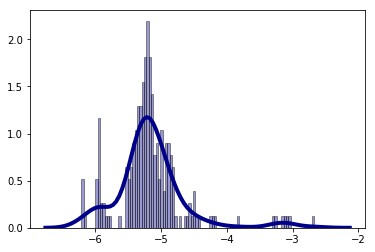

ctg_diffs: avg=-5.15, std=0.53, MSE=5879.58, MAE=5.15


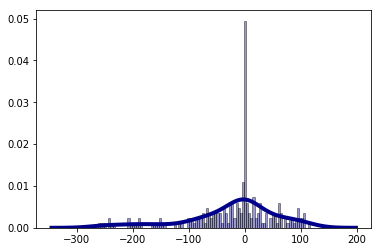

u_diffs: avg=-23.35, std=80.71, MSE=1546050.73, MAE=56.31
(219,) (219,)
R = [[ 1.         -0.50582692]
 [-0.50582692  1.        ]]


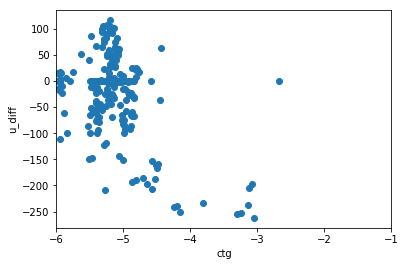

In [18]:
%matplotlib inline
import seaborn as sns


good_ctg_diffs = found_ctgs - expected_ctgs
good_u_diffs   = found_us - expected_us
print(good_ctg_diffs.shape, good_u_diffs.shape)

good_is = []
for i, (ctg_diff, u_diff) in enumerate(zip(good_ctg_diffs, good_u_diffs)):
    if ctg_diff < 2:
        good_is.append(i)
good_ctg_diffs = good_ctg_diffs[good_is]
good_u_diffs = good_u_diffs[good_is]
# print(list(zip(found_us, expected_us)))


def plot_and_print_statistics(diffs, name, bins=100, xlim=None):
    # density plot
    plt.figure()
    sns.distplot(diffs, hist=True, kde=True, 
             bins=bins, # ???
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
    if xlim is not None:
        plt.xlim(xlim)
    plt.show()
    
    avg = np.mean(diffs)
    std = np.std(diffs)
    MSE = np.sum(np.square(diffs))
    MAE = np.mean(np.abs(diffs))
    print("{}: avg={:.2f}, std={:.2f}, MSE={:.2f}, MAE={:.2f}".format(name, avg, std, MSE, MAE))


# cost_to_go     ctg_diffs
######################################################################
plot_and_print_statistics(good_ctg_diffs, "ctg_diffs")

# policy         u_diffs
######################################################################
plot_and_print_statistics(good_u_diffs, "u_diffs", 
#                           xlim=(-6, -1), 
#                           bins=500
                         )


# Here, I will plot all the VI and Policy things and evaluate correlation
######################################################################
print(good_ctg_diffs.shape, good_u_diffs.shape)
R = np.corrcoef(good_ctg_diffs, good_u_diffs)
print("R = {}".format(R))
plt.scatter(good_ctg_diffs, good_u_diffs)
plt.xlabel("ctg")
plt.ylabel("u_diff")
plt.xlim((-6, -1))


# Here I will generate the graph of for each subsection of cost_to_go graph,
# what is the distribution of policy outputs?
######################################################################

plt.show()


In [77]:
count = 0
for val in np.abs(policy.get_output_values()[0]):
    if val > 248:
        count += 1
print("{} / {}".format(count, len(policy.get_output_values()[0])))

127818 / 219849


In [68]:

# SUPER OVERFITTING + L2 + parameter distance metric!
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from nn_system.networks import FC, FCBIG, MLPSMALL, MLP, MLPBIG

# net = FCBIG(n_inputs=4, h_sz=8)
# net = FCBIG(n_inputs=4, h_sz=32) # <--- the one!
# net = MLP(n_inputs=4, h_sz=8)
# net = MLP(n_inputs=4, h_sz=256)#, dropout=True)
# net = MLPBIG(n_inputs=4, h_sz=256)#, dropout=True)

criterion = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(net.parameters(), 2e-6)


EPOCHS = 10

# My data
# np_cost_to_go = cost_to_go.reshape(19, 29, 21, 19)
np_policy = policy.get_output_values().reshape(19, 29, 21, 19)

def my_gen():
    for _ in range(100):
        N = 10000
        xs_idcs        = np.random.choice(19, N).astype(np.int)
        thetas_idcs    = np.random.choice(29, N).astype(np.int)
        xdots_idcs     = np.random.choice(21, N).astype(np.int)
        thetadots_idcs = np.random.choice(19, N).astype(np.int)
        
        xs        = xbins[xs_idcs]
        thetas    = thetabins[thetas_idcs]
        xdots     = xdotbins[xdots_idcs]
        thetadots = thetadotbins[thetadots_idcs]

        inputs = zip(xs, thetas, xdots, thetadots)
        idcs = tuple([xs_idcs, thetas_idcs, xdots_idcs, thetadots_idcs])

#         labels = np_cost_to_go[idcs].reshape(-1, 1).astype(np.double)
        labels = np_policy[idcs].reshape(-1, 1).astype(np.double)

        yield inputs, labels

for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(my_gen(), 0):
        # Unpack data
        inputs, labels = data
        inputs = torch.tensor(inputs)
        labels = torch.tensor(labels)

        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
        running_loss = 0.0

print('Finished Training')


[1,   100] loss: 7.690
[2,   100] loss: 8.204
[3,   100] loss: 8.196
[4,   100] loss: 8.457
[5,   100] loss: 8.856
[6,   100] loss: 8.814
[7,   100] loss: 8.748
[8,   100] loss: 8.172
[9,   100] loss: 8.112
[10,   100] loss: 8.769
Finished Training


In [9]:
# torch.save(net.state_dict(), "NN_MLPBIG_256_fit_to_cartpole_VI.pth")

In [69]:
from nn_system.NNSystem import NNSystem

# Animate the resulting policy.
builder = DiagramBuilder()
tree = RigidBodyTree("/opt/underactuated/src/cartpole/cartpole.urdf",
                     FloatingBaseType.kFixed)
plant = RigidBodyPlant(tree)
plant_system = builder.AddSystem(plant)


# TODO(russt): add wrap-around logic to barycentric mesh
# (so the policy has it, too)
class WrapTheta(VectorSystem):
    def __init__(self):
        VectorSystem.__init__(self, 4, 4)

    def _DoCalcVectorOutput(self, context, input, state, output):
        output[:] = input
        twoPI = 2.*math.pi
#         output[1] = output[1] - twoPI * math.floor(output[1] / twoPI)


wrap = builder.AddSystem(WrapTheta())
builder.Connect(plant_system.get_output_port(0), wrap.get_input_port(0))
vi_policy = builder.AddSystem(NNSystem(net))
# vi_policy = builder.AddSystem(policy)
builder.Connect(wrap.get_output_port(0), vi_policy.get_input_port(0))
builder.Connect(vi_policy.get_output_port(0), plant_system.get_input_port(0))

logger = builder.AddSystem(SignalLogger(4))
logger._DeclarePeriodicPublish(0.033333, 0.0)
builder.Connect(plant_system.get_output_port(0), logger.get_input_port(0))

diagram = builder.Build()
simulator = Simulator(diagram)
simulator.set_publish_every_time_step(False)

state = simulator.get_mutable_context().get_mutable_continuous_state_vector()
state.SetFromVector([0., math.pi, 0., 0.])

In [70]:
simulator.StepTo(3)

In [71]:
# Visualize the result as a video.
# vis = PendulumVisualizer()
vis = PlanarRigidBodyVisualizer(tree, xlim=[-12.5, 12.5], ylim=[-1, 2.5])
ani = vis.animate(logger, repeat=True)

# plt.show()λ 
# Things added to get visualizations in an ipynb
plt.close(vis.fig)
HTML(ani.to_html5_video())

## Can a net fit to this policy when it only get's stochastic samples of the known optimal policy

## Can traj opt inited with the above fitted optimal policy stay in place / find the optimal off of a small perturbation?

In [ ]:
# Gen a bunch of random initial conditions
n=15
# xs = np.random.uniform(-10, 10, n)
# x_dots = np.random.uniform(-4, 4, n)
# ics = [(x, x_dot) for x in xs for x_dot in x_dots]
# ics = np.array(ics)[good_is]
ics = good_ics

def eval_policy(x):
    mesh = policy.get_mesh()
    ovs  = policy.get_output_values()
    return mesh.Eval(ovs, x)

# Do dircol from them
# Compare policy at each knot point of the dircol solution!!!
knot_ics, knot_expected_us, knot_found_us, knot_SSE, knot_SAE = [], [], [], 0, 0
traj_ics, traj_expected_us, traj_found_us, traj_SSE, traj_SAE = [], [], [], 0, 0
for ic in ics:
    dircol, result = do_dircol(ic=ic, warm_start="linear", seed=1776, should_vis=False)
#     if result != SolutionResult.kSolutionFound:
#         continue
    # Could compare just the knot points...
    times   = dircol.GetSampleTimes().T
    x_knots = dircol.GetStateSamples().T
    u_knots = dircol.GetInputSamples().T
#     print(times.shape, x_knots.shape, u_knots.shape)
    assert len(times) == len(x_knots) and len(x_knots) == len(u_knots)
    for t, x, u in zip(times[:1], x_knots[:1], u_knots[:1]):
        expected_u = eval_policy(x)
        found_u    = u
#         print(expected_u, found_u)
        knot_ics.append(x)
        knot_expected_us.append(expected_u)
        knot_found_us.append(found_u)
        knot_SSE += (found_u - expected_u)**2
        knot_SAE += np.abs(found_u - expected_u)
    
    # ...and the interpolation points too!
    x_trajectory = dircol.ReconstructStateTrajectory()
    u_trajectory = dircol.ReconstructInputTrajectory()
    for t in np.linspace(times[0], times[-1], 100): # Pick uniform 100 times along the trajectory!
        x = x_trajectory.value(t)
        u = u_trajectory.value(t)
        expected_u = eval_policy(x)
        found_u    = u[0] # To go from shape (1, 1) -> (1,)
        traj_ics.append(x)
        traj_expected_us.append(expected_u)
        traj_found_us.append(found_u)
        traj_SSE += (found_u - expected_u)**2
        traj_SAE += np.abs(found_u - expected_u)

knot_MSE = knot_SSE / n
knot_MAE = knot_SAE / n
traj_MSE = traj_SSE / n
traj_MAE = traj_SAE / n

print("knot_MSE: {}, traj_MSE: {}".format(knot_MSE, traj_MSE))
print("knot_MAE: {}, traj_MAE: {}".format(knot_MAE, traj_MAE))

ics, expected_us, found_us = knot_ics, knot_expected_us, knot_found_us
# ics, expected_us, found_us = traj_ics, traj_expected_us, traj_found_us

zs = np.array(expected_us) - np.array(found_us)
u_diffs = zs*-1